# Redes Multicapa de Aerolíneas

## Procesamiento de datos

Procesamiento de datos de rutas aéreas por distintas aerolíneas en R para obtener matrices de adyacencia asociados a diferentes multiplex.

In [1]:
getwd()

[1] "/Users/Yuriko/Documents/UNAM/Tesis_Lic/Code"

In [2]:
setwd("/Users/Yuriko/Documents/UNAM/Tesis_Lic/")

## Librerías

In [3]:
# Librerías necesarias
library(tidyverse)
library(data.table)
library(igraph)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.0       ✔ purrr   0.3.2  
✔ tibble  2.1.1       ✔ dplyr   0.8.0.1
✔ tidyr   0.8.3       ✔ stringr 1.4.0  
✔ readr   1.3.1       ✔ forcats 0.4.0  
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘data.table’

The following objects are masked from ‘package:dplyr’:

    between, first, last

The following object is masked from ‘package:purrr’:

    transpose


Attaching package: ‘igraph’

The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union

The following objects are masked from ‘package:purrr’:

    compose, simplify

The following object is masked from ‘package:tidyr’:

    crossing

The following object is masked from ‘package:tibble’:

    as_data_frame

The following objects are masked from ‘package:stats’:

    decompose, spec

## Bases de datos

## Rutas Aéreas

### Base de datos Rutas Aéreas (OpenFlights/Airline Route Mapper Route Database)

As of ***June 2014***, the OpenFlights/Airline Route Mapper Route Database contains 67663 routes between 3321 airports on 548 airlines spanning the globe, as shown in the map above. Each entry contains the following information:

**Airline**	2-letter (IATA) or 3-letter (ICAO) code of the airline.  
**Airline ID**	Unique OpenFlights identifier for airline (see Airline).  
**Source airport**	3-letter (IATA) or 4-letter (ICAO) code of the source airport.  
**Source airport** ID	Unique OpenFlights identifier for source airport (see Airport)  
**Destination airport**	3-letter (IATA) or 4-letter (ICAO) code of the destination airport.  
**Destination airport ID**	Unique OpenFlights identifier for destination airport (see Airport)  
**Codeshare**	"Y" if this flight is a codeshare (that is, not operated by Airline, but another carrier), empty otherwise.  
**Stops**	Number of stops on this flight ("0" for direct)  
**Equipment**	3-letter codes for plane type(s) generally used on this flight, separated by spaces  

The data is UTF-8 encoded. The special value \N is used for "NULL" to indicate that no value is available, and is understood automatically by MySQL if imported.

*Notes:*  
Routes are directional: if an airline operates services from A to B and from B to A, both A-B and B-A are listed separately.  
Routes where one carrier operates both its own and codeshare flights are listed only once.

*Sample entries*  
BA,1355,SIN,3316,LHR,507,,0,744 777  
BA,1355,SIN,3316,MEL,3339,Y,0,744  
TOM,5013,ACE,1055,BFS,465,,0,320

##### La base de datos rutas_aereas.txt fue actualizada: # Date: 2014
Airline	Airline_ID	Source_Airport	Source_Airport_ID	Destination_Airport	Destination_Airport_ID	Codeshare	Stops_Number	Equipment
Líneas: 67663

In [4]:
## Se carga la tabla de rutas aéreas
#tabla_rutas <- data.table::fread(
#  input = "data/rutas_aereas.txt"
#)
#
#head(tabla_rutas)

### Base de datos Rutas Aéreas (Airline Route Mapper)

Last updated: ***March 29, 2019***

##### La base de datos routes.txt fue actualizada: # Date: 2019-03-29 
Airline	From	To	Codeshare	Stops	Equipment
#C7	MAO	CIZ		0	EMB
Líneas:33544

In [5]:
## Se carga la tabla de routes
#tabla_rutas2 <- data.table::fread(
#  input = "data/routes.txt"
#)
#
#head(tabla_rutas2)

### Base de datos Rutas Aéreas (Airline Route Mapper GitHub) que se utilizó para el análisis

Last updated: ***2017***

In [6]:
# Se carga la tabla de rutas de 2017

tabla_rutas2017 <- data.table::fread(
  input = "data/rutas17.txt"
)

head(tabla_rutas2017)

Airline,Airline_ID,From,From_ID,To,To_ID,Codeshare,Stops,Equipment
2B,410,AER,2965,KZN,2990,,0,CR2
2B,410,ASF,2966,KZN,2990,,0,CR2
2B,410,ASF,2966,MRV,2962,,0,CR2
2B,410,CEK,2968,KZN,2990,,0,CR2
2B,410,CEK,2968,OVB,4078,,0,CR2
2B,410,DME,4029,KZN,2990,,0,CR2


## Aerolíneas

### Base de datos Aerolíneas (OpenFlights Airlines Database)

As of ***January 2012***, the OpenFlights Airlines Database contains 5888 airlines. Each entry contains the following information:

**Airline ID**	Unique OpenFlights identifier for this airline.  
**Name**	Name of the airline.  
**Alias**	Alias of the airline. For example, All Nippon Airways is commonly known as "ANA".  
**IATA**	2-letter IATA code, if available.  
**ICAO**	3-letter ICAO code, if available.  
**Callsign**	Airline callsign.  
**Country**	Country or territory where airline is incorporated.  
**Active**	"Y" if the airline is or has until recently been operational, "N" if it is defunct. This field is not reliable: in particular, major airlines that stopped flying long ago, but have not had their IATA code reassigned (eg. Ansett/AN), will incorrectly show as "Y".  

The data is UTF-8 encoded. The special value \N is used for "NULL" to indicate that no value is available, and is understood automatically by MySQL if imported.  

*Notes:*   
Airlines with null codes/callsigns/countries generally represent user-added airlines. Since the data is intended primarily for current flights, defunct IATA codes are generally not included. For example, "Sabena" is not listed with a SN IATA code, since "SN" is presently used by its successor Brussels Airlines.  

*Sample entries*.  
324,"All Nippon Airways","ANA All Nippon Airways","NH","ANA","ALL NIPPON","Japan","Y"  
412,"Aerolineas Argentinas",\N,"AR","ARG","ARGENTINA","Argentina","Y"  
413,"Arrowhead Airways",\N,"","ARH","ARROWHEAD","United States","N"  

##### La base de datos aerolineas.txt fue actualizada: # Date:  Enero 2012
Líneas: 6160

In [7]:
## Se carga la tabla de aerolíneas
#tabla_aerol <- data.table::fread(
#  input = "data/aerolineas.txt"
#  )
#
#head(tabla_aerol)

### Base de datos Aerolíneas (Airline Route Mapper)

##### La base de datos airlines.txt fue actualizada: # Date: 2019-03-29 ?
Airline_ID	Airline_Name
Líneas: 689

In [153]:
# Se carga la tabla de airlines
tabla_aerolineas <- data.table::fread(
  input = "data/airlines.txt"
  )

head(tabla_aerolineas)

Airline_ID,Airline_Name
0B,Blue Air
0V,Vasco - Vietnam Air Services Company
1X,Branson Air Express
2B,Albawings
2G,Angara Airlines
2I,Star Peru


In [155]:
str(tabla_aerolineas) #689 aerolineas activas 

Classes ‘data.table’ and 'data.frame':	689 obs. of  2 variables:
 $ Airline_ID  : chr  "0B" "0V" "1X" "2B" ...
 $ Airline_Name: chr  "Blue Air" "Vasco - Vietnam Air Services Company" "Branson Air Express" "Albawings" ...
 - attr(*, ".internal.selfref")=<externalptr> 


In [152]:
tabla_aerolineas2 %>% dplyr::filter(Airline_ID == "MU")

Airline_ID,Airline_Name
MU,China Eastern Airlines


## Aeropuertos

### Base de datos Aeropuertos (OpenFlights Airports Database)

As of ***January 2017***, the OpenFlights Airports Database contains over 10,000 airports, train stations and ferry terminals spanning the globe, as shown in the map above. Each entry contains the following information:

**Airport ID**	Unique OpenFlights identifier for this airport.  
**Name**	Name of airport. May or may not contain the City name.  
**City**	Main city served by airport. May be spelled differently from Name.  
**Country**	Country or territory where airport is located. See countries.dat to cross-reference to ISO 3166-1 codes.  
**IATA**	3-letter IATA code. Null if not assigned/unknown.  
**ICAO**	4-letter ICAO code. Null if not assigned.  
**Latitude**	Decimal degrees, usually to six significant digits. Negative is South, positive is North.  
**Longitude**	Decimal degrees, usually to six significant digits. Negative is West, positive is East.  
**Altitude**	In feet.  
**Timezone**	Hours offset from UTC. Fractional hours are expressed as decimals, eg. India is 5.5.  
**DST**	Daylight savings time. One of E (Europe), A (US/Canada), S (South America), O (Australia), Z (New Zealand), N (None) or U (Unknown). See also: Help: Time  
**Tz database time zone**	Timezone in "tz" (Olson) format, eg. "America/Los_Angeles".  
**Type**	Type of the airport. Value "airport" for air terminals, "station" for train stations, "port" for ferry terminals and "unknown" if not known. In airports.csv, only type=airport is included.  
**Source**	Source of this data. "OurAirports" for data sourced from OurAirports, "Legacy" for old data not matched to OurAirports (mostly DAFIF), "User" for unverified user contributions. In airports.csv, only source=OurAirports is included.  

The data is UTF-8 encoded.  

*Note:*   
Rules for daylight savings time change from year to year and from country to country. The current data is an approximation for 2009, built on a country level. Most airports in DST-less regions in countries that generally observe DST (eg. AL, HI in the USA, NT, QL in Australia, parts of Canada) are marked incorrectly.

*Sample entries*.  
507,"London Heathrow Airport","London","United Kingdom","LHR","EGLL",51.4706,-0.461941,83,0,"E","Europe/London","airport","OurAirports"  
26,"Kugaaruk Airport","Pelly Bay","Canada","YBB","CYBB",68.534401,-89.808098,56,-7,"A","America/Edmonton","airport","OurAirports"  
3127,"Pokhara Airport","Pokhara","Nepal","PKR","VNPK",28.200899124145508,83.98210144042969,2712,5.75,"N","Asia/Katmandu","airport","OurAirports"  
8810,"Hamburg Hbf","Hamburg","Germany","ZMB",\N,53.552776,10.006683,30,1,"E","Europe/Berlin","station","User"

##### La base de datos aeropuertos.txt fue actualizada: # Date:  
Líneas: 7543

In [9]:
# Se carga la tabla de aeropuertos
tabla_aeropuertos <- data.table::fread(
  input = "data/aeropuertos.txt"
  )

head(tabla_aeropuertos)

Airport_ID,Name,City,Country,IATA,ICAO,Latitude,Longitude,Altitude,Timezone,DST,Tz_database_time_zone,Type,Source
1,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.081690,145.392,5282,10,U,Pacific/Port_Moresby,airport,OurAirports
2,Madang Airport,Madang,Papua New Guinea,MAG,AYMD,-5.207080,145.789,20,10,U,Pacific/Port_Moresby,airport,OurAirports
3,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,AYMH,-5.826790,144.296,5388,10,U,Pacific/Port_Moresby,airport,OurAirports
4,Nadzab Airport,Nadzab,Papua New Guinea,LAE,AYNZ,-6.569803,146.726,239,10,U,Pacific/Port_Moresby,airport,OurAirports
5,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,POM,AYPY,-9.443380,147.220,146,10,U,Pacific/Port_Moresby,airport,OurAirports
6,Wewak International Airport,Wewak,Papua New Guinea,WWK,AYWK,-3.583830,143.669,19,10,U,Pacific/Port_Moresby,airport,OurAirports


##### La base de datos airports.txt fue actualizada: # Date: 2019-03-29 líneas:5819
Airport_ID	Latitude	Longitude	Airport_Name

In [10]:
## Se carga la tabla de airports
#tabla_aeropuertos2 <- data.table::fread(
#  input = "data/airports.txt"
#  )
#
#head(tabla_aeropuertos2)

In [11]:
## Se carga la tabla de our airports
#tabla_aeropuertos3 <- data.table::fread(
#  input = "data/our_airports.txt"
#  )
#
#head(tabla_aeropuertos3)

##### La base de datos alliances.txt fue actualizada: # Date: 2019-03-29 líneas:15
Alliance_Name  List_of_Airlines

In [12]:
## Se carga la tabla de alianzas
#tabla_alianzas <- data.table::fread(
#  input = "data/alliances.txt"
#  )
#
#tabla_alianzas

## Procesamiento

In [13]:
#names(tabla_aerolineas)

In [14]:
## Renombramos las columnas de la tabla de aerolíneas
#names(tabla_aerolineas) <- c("Airline ID", 
#                             "Name", 
#                             "Alias", 
#                             "IATA", 
#                             "ICAO", 
#                             "Callsign", 
#                             "Country", 
#                             "Active"
#                              )

In [15]:
## Checamos la tabla_aerolíneas con los nuevos nombres
#tabla_aerolineas %>% head  

In [16]:
## Quitamos el primer renglón de la tabla_aerolíneas
#tabla_aerolineas <- tabla_aerolineas [-c(1), ]

In [17]:
##Checamos la tabla_aerolíneas
#tabla_aerolineas %>% head 

In [18]:
#head(tabla_rutas)

In [19]:
##Quitamos columnas de ID que no necesitamos de tabla_rutas
#tabla_rutas <- tabla_rutas %>%
#  dplyr::select(Airline,
#                Source_Airport,
#                Destination_Airport,
#                Codeshare,
#                Stops_Number,
#                Equipment)

In [20]:
##Checamos la tabla_rutas
#tabla_rutas %>% head

In [21]:
##Ahora hacemos un ciclo que recorra toda la tabla_aerolíneas, el cual 
##remueva los renglones correspondientes a las aerolíneas que NO están activas.
#
#tabla_aerolineas <- tabla_aerolineas %>% 
#  dplyr::filter(Active == "Y")

In [22]:
##Checamos la tabla_aerolineas
#tabla_aerolineas %>% head

In [23]:
#Falta remover los renglones de la tabla_aeropuertos que contienen algún aeropuerto inactivo

In [24]:
##Checamos la tabla_aeropuertos
#tabla_aeropuertos %>% head

In [25]:
##Encontramos la intersección entre tabla_aerolineas y tabla_rutas
##para usar sólo las rutas de las aerolíneas activas.
#tabla_rutas <- semi_join(tabla_rutas, tabla_aerolineas, by = c("Airline" = "IATA"))

In [26]:
#Encontramos la intersección entre tabla_aeropuertos y tabla_rutas
#para usar sólo las rutas de las aeropuertos activos.

In [27]:
##Checamos la tabla_rutas modificada
#tabla_rutas %>% head

In [28]:
##Checamos la tabla_rutas2
#tabla_rutas2 %>% head

In [29]:
##Quitamos el primer y segundo renglón de la tabla_aerolíneas
#tabla_rutas2 <- tabla_rutas2 [-c(2), ]

In [30]:
##Checamos tabla_rutas2
#tabla_rutas2 %>% head

In [31]:
## Renombramos las columnas de la tabla_rutas2
#names(tabla_rutas2) <- c("Airline", 
#                         "Source", 
#                         "Destination", 
#                         "Codeshare", 
#                         "Stops", 
#                         "Equipment"
#)

In [32]:
##Checamos tabla_rutas2
#tabla_rutas2 %>% head

In [33]:
##Encontramos la intersección entre tabla_aerolineas y tabla_rutas2
##para usar sólo las rutas de las aerolíneas activas.
#tabla_rutas2 <- semi_join(tabla_rutas2, tabla_aerolineas, by = c("Airline" = "IATA"))

In [34]:
#str(tabla_rutas) #2014

In [35]:
#str(tabla_rutas2) #2019

Puesto que tabla_rutas2 contiene menos datos, usaremos esos...

In [36]:
##Queremos converir la columna de Codeshare a booleano
#tabla_rutas2 <- tabla_rutas2 %>%
#  dplyr::mutate(Codeshare = ifelse(test = Codeshare == "*",
#                                   yes = TRUE,
#                                   no = FALSE
#  )
#  )

In [37]:
##Checamos
#tabla_rutas2 %>% head

In [38]:
##Ahora voy a quitar las rutas que contienen escalas, 
##i.e. los que son distintos de 0 en "Stops_Number"
#tabla_rutas2 <- tabla_rutas2 %>% 
#  dplyr::filter(Stops == 0)

In [39]:
##Checamos
#tabla_rutas2 %>% head

In [40]:
##Ahora voy a quitar las rutas que contienen Codeshare, 
##i.e. los que son TRUE en "Codeshare"
#tabla_rutas2 <- tabla_rutas2 %>%
#  dplyr::filter(Codeshare == FALSE)

In [41]:
##Checamos
#tabla_rutas2

In [42]:
##Cambio orden de columnas
#tabla_rutas2[ , -1]
#tabla_rutas2[ , 1]
#
#da.fr <- cbind(tabla_rutas2[,-1], 
#               Airline = tabla_rutas2$Airline
#)

In [43]:
##Checo cómo se ve
#da.fr %>% head

In [44]:
##Hago red
#g <- igraph::graph_from_data_frame(d = da.fr, 
#                                   directed = TRUE)
#g

In [45]:
#is.simple(g)

### Usamos la tabla_rutas17 para el análisis (de GitHub, actualizada en 2017)

In [46]:
str(tabla_rutas2017)

Classes ‘data.table’ and 'data.frame':	67663 obs. of  9 variables:
 $ Airline   : chr  "2B" "2B" "2B" "2B" ...
 $ Airline_ID: chr  "410" "410" "410" "410" ...
 $ From      : chr  "AER" "ASF" "ASF" "CEK" ...
 $ From_ID   : chr  "2965" "2966" "2966" "2968" ...
 $ To        : chr  "KZN" "KZN" "MRV" "KZN" ...
 $ To_ID     : chr  "2990" "2990" "2962" "2990" ...
 $ Codeshare : chr  "" "" "" "" ...
 $ Stops     : int  0 0 0 0 0 0 0 0 0 0 ...
 $ Equipment : chr  "CR2" "CR2" "CR2" "CR2" ...
 - attr(*, ".internal.selfref")=<externalptr> 


In [47]:
tabla_rutas2017$Codeshare %>% unique

[1] ""  "Y"

In [48]:
#Queremos converir la columna de Codeshare a booleano
tabla_rutas17 <- tabla_rutas2017 %>%
  dplyr::mutate(Codeshare = ifelse(test = Codeshare == "Y",
                                   yes = TRUE,
                                   no = FALSE
  )
  )

In [49]:
str(tabla_rutas17)

'data.frame':	67663 obs. of  9 variables:
 $ Airline   : chr  "2B" "2B" "2B" "2B" ...
 $ Airline_ID: chr  "410" "410" "410" "410" ...
 $ From      : chr  "AER" "ASF" "ASF" "CEK" ...
 $ From_ID   : chr  "2965" "2966" "2966" "2968" ...
 $ To        : chr  "KZN" "KZN" "MRV" "KZN" ...
 $ To_ID     : chr  "2990" "2990" "2962" "2990" ...
 $ Codeshare : logi  FALSE FALSE FALSE FALSE FALSE FALSE ...
 $ Stops     : int  0 0 0 0 0 0 0 0 0 0 ...
 $ Equipment : chr  "CR2" "CR2" "CR2" "CR2" ...


In [50]:
#Quitamos los renglones correspondientes a rutas aéreas que tienen escalas y codeshare.
tabla_rutas17f <- tabla_rutas17 %>% 
  dplyr::filter(Stops == 0,
                Codeshare == FALSE)
tabla_rutas17f %>% head 

Airline,Airline_ID,From,From_ID,To,To_ID,Codeshare,Stops,Equipment
2B,410,AER,2965,KZN,2990,FALSE,0,CR2
2B,410,ASF,2966,KZN,2990,FALSE,0,CR2
2B,410,ASF,2966,MRV,2962,FALSE,0,CR2
2B,410,CEK,2968,KZN,2990,FALSE,0,CR2
2B,410,CEK,2968,OVB,4078,FALSE,0,CR2
2B,410,DME,4029,KZN,2990,FALSE,0,CR2


In [147]:
#Busco qué aeropuerto es US
tabla_rutas2017 %>% dplyr::filter(Airline == "US")

Airline,Airline_ID,From,From_ID,To,To_ID,Codeshare,Stops,Equipment
US,5265,ABE,4355,CLT,3876,Y,0,CR9 CR7 CRJ
US,5265,ABE,4355,PHL,3752,Y,0,CRJ DH8
US,5265,ABI,3718,DFW,3670,,0,ERD ER4
US,5265,ABQ,4019,DFW,3670,,0,M83 M80
US,5265,ABQ,4019,LAX,3484,Y,0,CR7 CRJ
US,5265,ABQ,4019,ORD,3830,,0,E75
US,5265,ABQ,4019,PHX,3462,Y,0,CRJ CR9
US,5265,ACT,3700,DFW,3670,,0,ER4
US,5265,ADL,3341,AKL,2006,Y,0,320
US,5265,AEX,3852,DFW,3670,Y,0,ER4 CRJ ERD


In [51]:
#Quitamos columnas de ID
tabla_rutas17f <- tabla_rutas17f %>%
  dplyr::select(Airline,
                From,
                To,
                Codeshare,
                Stops,
                Equipment)
tabla_rutas17f %>% head

Airline,From,To,Codeshare,Stops,Equipment
2B,AER,KZN,FALSE,0,CR2
2B,ASF,KZN,FALSE,0,CR2
2B,ASF,MRV,FALSE,0,CR2
2B,CEK,KZN,FALSE,0,CR2
2B,CEK,OVB,FALSE,0,CR2
2B,DME,KZN,FALSE,0,CR2


In [52]:
#Cambiamos el orden de las columnas para hacer el grafo
#col_order <- c(("From", "To", "Codeshare", "Stops", "Equipment", "Airline"))
rutas17f <- tabla_rutas17f[, c(2, 3, 4, 5, 6, 1)]
rutas17f %>% head

From,To,Codeshare,Stops,Equipment,Airline
AER,KZN,FALSE,0,CR2,2B
ASF,KZN,FALSE,0,CR2,2B
ASF,MRV,FALSE,0,CR2,2B
CEK,KZN,FALSE,0,CR2,2B
CEK,OVB,FALSE,0,CR2,2B
DME,KZN,FALSE,0,CR2,2B


In [53]:
# Checamos la estructura de la tabla
str(rutas17f)

'data.frame':	53055 obs. of  6 variables:
 $ From     : chr  "AER" "ASF" "ASF" "CEK" ...
 $ To       : chr  "KZN" "KZN" "MRV" "KZN" ...
 $ Codeshare: logi  FALSE FALSE FALSE FALSE FALSE FALSE ...
 $ Stops    : int  0 0 0 0 0 0 0 0 0 0 ...
 $ Equipment: chr  "CR2" "CR2" "CR2" "CR2" ...
 $ Airline  : chr  "2B" "2B" "2B" "2B" ...


In [54]:
# Creamos el grafo a partir de la tabla
g17 <- graph_from_data_frame(rutas17f, directed = TRUE)

Se grafican las rutas aéreas de todas las aerolíneas como una red monocapa.

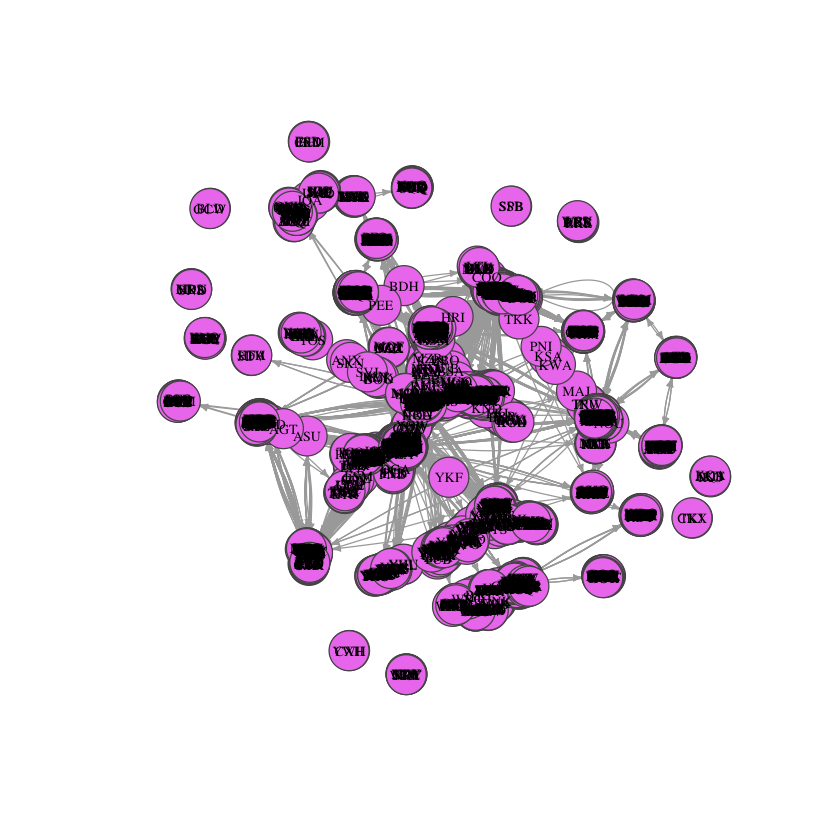

In [55]:
#Graficamos todo en una capa
plot(g17, 
     edge.arrow.size = .4, 
     edge.curved = .1,
     vertex.color = "violet", 
     vertex.frame.color = "#555555",
     vertex.label.color = "black",
     vertex.label.cex = .7)

In [56]:
#Distribución de grado de entrada
degree(g17, mode = "in") %>% table

.
  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19 
 10 793 523 322 218 171 113  85  70  62  52  34  34  31  41  19  25  23  17  19 
 20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39 
 18  11  15  11  10   7  15  12   8   5   6  22   5   9   8   5  10   7   9   5 
 40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59 
  6   6   4  10   7   3   6   6   5   2   8   2   6   1   8   3   2   2   6   4 
 60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  81 
  3   3   3   5   4   3   4   3   3   4   2   3   2   3   2   4   4   1   2   4 
 82  83  84  87  88  89  90  91  92  93  94  95  96  97  98 100 101 102 105 106 
  1   2   3   4   3   3   2   2   3   1   4   2   4   2   5   4   3   1   3   2 
107 108 109 111 112 113 114 115 116 118 122 123 124 125 130 131 132 133 134 136 
  1   2   1   1   3   1   1   1   3   1   1   1   3   2   1   1   1   1   2   1 
138 139 142 143 144 148 15

In [57]:
#Distribución de grado de salida
degree(g17, mode = "out") %>% table

.
  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19 
 23 785 521 322 227 169 106  83  75  52  55  35  33  34  35  25  23  18  21  18 
 20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39 
 16  13  19   8  10  14   8  10   9  10   6  17   8  10   6   6   7   7  10   6 
 40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59 
  7   6   8   6   2   7   6   3   7   5   6   1   8   7   3   1   5   1   5   4 
 60  61  62  63  64  65  66  67  68  69  71  72  73  74  75  76  77  78  79  81 
  4   1   6   1   3   5   5   2   3   5   3   2   2   4   2   2   5   1   3   1 
 82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101 
  3   2   4   1   2   3   1   1   3   3   2   4   4   1   3   1   3   1   2   4 
102 105 106 107 108 109 111 112 114 115 116 117 118 122 123 124 126 131 132 134 
  2   1   1   4   2   1   3   1   1   2   1   2   1   1   1   4   1   2   1   1 
135 136 137 139 141 142 14

In [58]:
#¿Cuántas aerolíneas diferentes tenemos?
rutas17f$Airline %>% unique %>% length

[1] 567

In [59]:
#Saco una tabla sólo de codeshares de la 2017
tabla_rutas17_codeshare <- tabla_rutas17 %>% 
  dplyr::filter(Codeshare == TRUE)

tabla_rutas17_codeshare %>% head

Airline,Airline_ID,From,From_ID,To,To_ID,Codeshare,Stops,Equipment
2P,897,GES,2402,MNL,2397,TRUE,0,320
2P,897,MNL,2397,GES,2402,TRUE,0,320
4M,3201,DFW,3670,EZE,3988,TRUE,0,777
4M,3201,EZE,3988,DFW,3670,TRUE,0,777
4M,3201,EZE,3988,JFK,3797,TRUE,0,777
4M,3201,JFK,3797,EZE,3988,TRUE,0,777


In [60]:
#Estructura. 14597 rutas con Codeshare
str(tabla_rutas17_codeshare)

'data.frame':	14597 obs. of  9 variables:
 $ Airline   : chr  "2P" "2P" "4M" "4M" ...
 $ Airline_ID: chr  "897" "897" "3201" "3201" ...
 $ From      : chr  "GES" "MNL" "DFW" "EZE" ...
 $ From_ID   : chr  "2402" "2397" "3670" "3988" ...
 $ To        : chr  "MNL" "GES" "EZE" "DFW" ...
 $ To_ID     : chr  "2397" "2402" "3988" "3670" ...
 $ Codeshare : logi  TRUE TRUE TRUE TRUE TRUE TRUE ...
 $ Stops     : int  0 0 0 0 0 0 0 0 0 0 ...
 $ Equipment : chr  "320" "320" "777" "777" ...


In [61]:
#Busco la ruta DEN-LAX
tabla_rutas17 %>% dplyr::filter(From == "DEN" & To == "LAX")

Airline,Airline_ID,From,From_ID,To,To_ID,Codeshare,Stops,Equipment
AA,24,DEN,3751,LAX,3484,TRUE,0,CR7
AS,439,DEN,3751,LAX,3484,TRUE,0,CR7
F9,2468,DEN,3751,LAX,3484,FALSE,0,319 320
FL,1316,DEN,3751,LAX,3484,TRUE,0,73W 73C
UA,5209,DEN,3751,LAX,3484,FALSE,0,739 320 319 738 753 752
US,5265,DEN,3751,LAX,3484,FALSE,0,CR7
WN,4547,DEN,3751,LAX,3484,FALSE,0,733 73H 73C 73W


Obtenemos la matriz de adyacencia.

In [62]:
matriz_multiplex <- as_adjacency_matrix(g17)
matriz_multiplex
#Recordemos que los pesos corresponden a rutas iguales de diferentes aerolíneas, como se prueba abajo.

   [[ suppressing 32 column names ‘AER’, ‘ASF’, ‘CEK’ ... ]]
   [[ suppressing 32 column names ‘AER’, ‘ASF’, ‘CEK’ ... ]]
   [[ suppressing 32 column names ‘AER’, ‘ASF’, ‘CEK’ ... ]]


3189 x 3189 sparse Matrix of class "dgCMatrix"
                                                                          
AER . . . 4 . . . 1 1 . . . . . 2 . . . . . . . . . . . . . . . . . ......
ASF . . . 2 . . . 1 1 1 . . . . . . . . . . . . . . . . . . . . . . ......
CEK . . . 2 . . . 1 1 . . . . 2 . . . . . . . . . . . . . . . . . . ......
DME 3 2 2 . 3 2 3 4 5 3 1 2 3 3 3 1 1 1 1 2 . 1 . . . 1 . . . . . . ......
EGO . . . 3 . . 1 1 1 . . . . . . . . . . . . . . . . . . . . . . . ......
GYD . . . 2 . . . . 2 1 1 . . 2 2 . . . . . . . . . . . . . . . . . ......
KGD . . . 3 1 . . . 1 . . . . . . . . . . . . . . . . . . . . . . . ......
KZN 1 1 1 4 1 . . . 3 . . . . . 1 . . . . . . . . . . . . . . . . . ......
LED 1 1 1 5 1 2 1 3 . 1 1 . . 3 2 . 1 . . . . . . . . 1 . . . . . . ......
MRV . 1 . 3 . 1 . . 1 . . . . . 3 . . . . . . . . . . . . . . . . . ......
NBC . . . 1 . 1 . . 1 . . . . . 1 . . . . . . . . . . . . . . . . . ......
NJC . . . 1 . . . . . . . . . 3 2 . 2 . . . . . . . .

In [63]:
#Primero la convertimos a matrix
matriz_multiplex <- as.matrix(matriz_multiplex)
str(matriz_multiplex)

 num [1:3189, 1:3189] 0 0 0 3 0 0 0 1 1 0 ...
 - attr(*, "dimnames")=List of 2
  ..$ : chr [1:3189] "AER" "ASF" "CEK" "DME" ...
  ..$ : chr [1:3189] "AER" "ASF" "CEK" "DME" ...


Pasamos la matriz de adyacencia a una de 0's y 1's, es decir, no pesada

In [64]:
# Convertimos matriz_multiplex a una matriz de adyacencia dirigida y no pesada.
matriz_multiplex_du <- ifelse(matriz_multiplex == 0,
                                yes = 0,
                                 no = 1) 

matriz_multiplex_du

,AER,ASF,CEK,DME,EGO,GYD,KGD,KZN,LED,MRV,⋯,BVS,MTE,DLZ,UII,ZBF,CMP,BSS,AEX,GCK,MGM
AER,0,0,0,1,0,0,0,1,1,0,⋯,0,0,0,0,0,0,0,0,0,0
ASF,0,0,0,1,0,0,0,1,1,1,⋯,0,0,0,0,0,0,0,0,0,0
CEK,0,0,0,1,0,0,0,1,1,0,⋯,0,0,0,0,0,0,0,0,0,0
DME,1,1,1,0,1,1,1,1,1,1,⋯,0,0,0,0,0,0,0,0,0,0
EGO,0,0,0,1,0,0,1,1,1,0,⋯,0,0,0,0,0,0,0,0,0,0
GYD,0,0,0,1,0,0,0,0,1,1,⋯,0,0,0,0,0,0,0,0,0,0
KGD,0,0,0,1,1,0,0,0,1,0,⋯,0,0,0,0,0,0,0,0,0,0
KZN,1,1,1,1,1,0,0,0,1,0,⋯,0,0,0,0,0,0,0,0,0,0
LED,1,1,1,1,1,1,1,1,0,1,⋯,0,0,0,0,0,0,0,0,0,0
MRV,0,1,0,1,0,1,0,0,1,0,⋯,0,0,0,0,0,0,0,0,0,0


Ahora guardo esta matriz "matriz_multiplex_du" 

In [65]:
##write.csv(matriz_multiplex_du, "data/matriz_multiplex_du.csv")

Pruebas para ver por qué la matriz de adyacencia de la matriz_multi tiene pesos.

In [66]:
#pruebaOTP <- tabla_rutas2 %>%
#  dplyr::filter(From == "OTP")

In [67]:
#pruebaOTP %>% head

In [68]:
#str(pruebaOTP)

In [69]:
#pruebaOTP20 <- pruebaOTP %>%
#  dplyr::filter(To == "BCM")

In [70]:
#pruebaOTP20

In [71]:
#pruebaOTP21 <- pruebaOTP %>%
#  dplyr::filter(To == "CLJ")

In [72]:
#pruebaOTP21

De estas pruebas concluimos que los pesos de la matriz_multi corresponden a rutas entre los mismos aeropuertos pero de diferentes aerolíneas.

Así que, la matriz de adyacencia que usaremos es una en la que convirtamos los pesos a 1's.

In [73]:
##Primero la convertimos a matrix
#matriz_multi <- as.matrix(matriz_multi)

In [74]:
#str(matriz_multi)

In [75]:
#matriz_multi

In [76]:
## Convertimos matriz_multi a una matriz de adyacencia dirigida y no pesada.
#matriz_multi_uw <- ifelse(matriz_multi == 0,
#                            yes = 0,
#                             no = 1) 

In [77]:
#matriz_multi_uw

Ahora guardo esta matriz "matriz_multi_uw" 

In [78]:
#write.csv(matriz_multi_uw, "data/matriz_multi_uw.csv")

In [79]:
#write.matrix

### Medidas de centralidad de esta red monocapa de rutas.

In [80]:
#Grado
degree(g17) %>% head

AER ASF CEK DME EGO GYD 
 52  16  40 597  22 108

In [81]:
#Distribución de grado


In [82]:
#Estructura de degree(g)
str(degree(g17))

 Named num [1:3189] 52 16 40 597 22 108 28 56 348 44 ...
 - attr(*, "names")= chr [1:3189] "AER" "ASF" "CEK" "DME" ...


In [83]:
#Average Shortest Path Length
average.path.length(g17)

[1] 4.184484

In [84]:
#Betweenness
betweenness(g17) %>% head

AER          ASF          CEK          DME          EGO          GYD 
2.783243e+02 4.755776e+00 3.481884e+01 3.291271e+05 1.558492e+00 2.945702e+03

In [85]:
#Diámetro
diameter(g17)

[1] 15

In [86]:
#Radio
radius(g17)

[1] 1

In [87]:
#Excentricidad
eccentricity(g17) %>% head

AER ASF CEK DME EGO GYD 
  9   9   9   9  10   9

In [88]:
#Transitivity/Clustering Coefficient
transitivity(g17)

[1] 0.2501483

#### Para crear la red multicapa

In [89]:
str(rutas17f)

'data.frame':	53055 obs. of  6 variables:
 $ From     : chr  "AER" "ASF" "ASF" "CEK" ...
 $ To       : chr  "KZN" "KZN" "MRV" "KZN" ...
 $ Codeshare: logi  FALSE FALSE FALSE FALSE FALSE FALSE ...
 $ Stops    : int  0 0 0 0 0 0 0 0 0 0 ...
 $ Equipment: chr  "CR2" "CR2" "CR2" "CR2" ...
 $ Airline  : chr  "2B" "2B" "2B" "2B" ...


In [90]:
#Vemos cuántas aerolíneas distintas tenemos
length(unique(rutas17f$Airline))

[1] 567

In [91]:
#Tomo todas las aerolíneas posibles con unique
#Como las aerolíneas son de tipo Factor, lo convierto a caracteres 

mis_aerolineas <- unique(rutas17f$Airline)
mis_aerolineas %>% head
#mis_aerolineas <- as.character(unique(da.fr$Airline)) 

[1] "2B" "2G" "2I" "2J" "2K" "2L"

In [92]:
#La lista "hereda" los nombres
names(mis_aerolineas) <- mis_aerolineas
mis_aerolineas %>% head

2B   2G   2I   2J   2K   2L 
"2B" "2G" "2I" "2J" "2K" "2L"

In [93]:
#write.csv(mis_aerolineas, file = paste("data/aerolineas_matrices/","lista_aerolineas.csv"))

In [94]:
#Se aplica el filtrado para aerolíneas, que corresponderán a distintas capas 
#y le agrega el grafo g a cada capa

graph_capas <- lapply(mis_aerolineas, FUN = function(i){
  ruta_aerol <- dplyr::filter(.data = rutas17f, Airline == i)
  g <- igraph::graph_from_data_frame(d = ruta_aerol, 
                                     directed = TRUE)
}) 

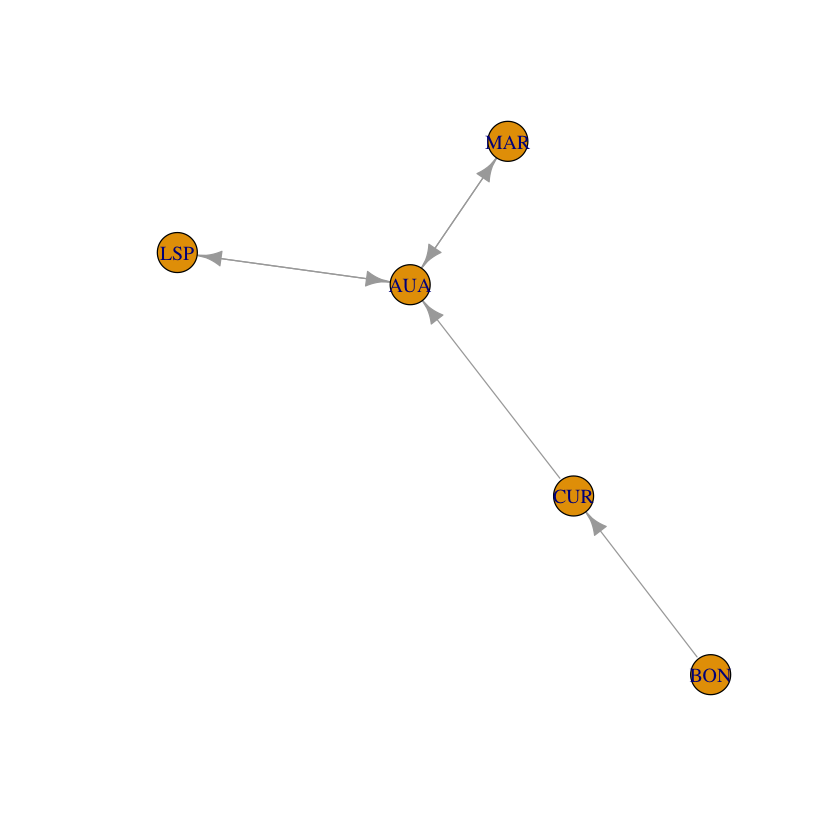

In [95]:
#Eg. Se grafica la red de la capa correspondiente a la aerolínea 2B
plot(graph_capas$`3P`)

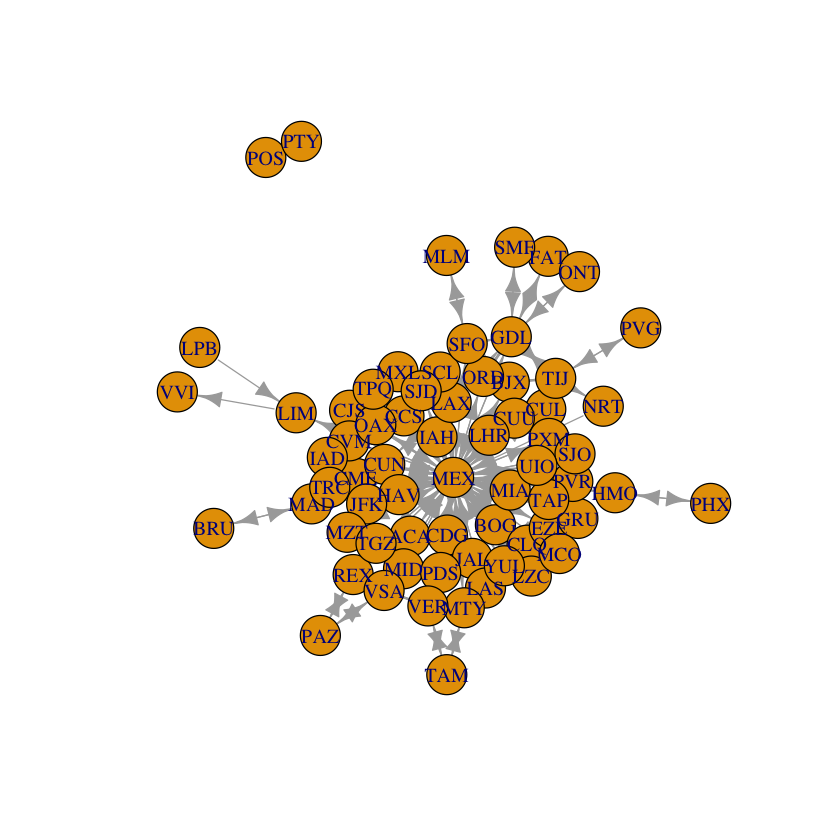

In [96]:
#Eg. Se grafica la red de la capa correspondiente a la aerolínea AM
plot(graph_capas$AM)

##### ¿Por qué aparece el aeropuerto POS en esta aerolínea desconectado?

In [97]:
#Busco la ruta MEX-POS
tabla_rutas2017 %>% dplyr::filter(From == "MEX" & To == "POS")

Airline,Airline_ID,From,From_ID,To,To_ID,Codeshare,Stops,Equipment


In [98]:
tabla_rutas2017 %>% dplyr::filter(Airline == "AM" & From == "POS")

Airline,Airline_ID,From,From_ID,To,To_ID,Codeshare,Stops,Equipment
AM,321,POS,2902,PTY,1871,,0,73G E90


In [99]:
tabla_rutas2017 %>% dplyr::filter(Airline == "AM" & To == "POS")

Airline,Airline_ID,From,From_ID,To,To_ID,Codeshare,Stops,Equipment
AM,321,PTY,1871,POS,2902,,0,73G E90


In [100]:
degree(graph_capas$AM)

ACA BJX BOG BRU CCS CDG CJS CLQ CME CUL CUN CUU CVM EZE FAT GDL GRU HAV HMO IAD 
  2   6   2   2   2   2   2   2   2   4  10   2   2   2   2  16   2   4   4   2 
IAH JAL JFK LAS LAX LHR LIM LPB LZC MAD MCO MEX MIA MID MLM MTY MXL MZT NRT OAX 
  2   2   4   4   7   2   4   1   2   6   2 105   2   4   2   6   2   2   2   2 
ONT ORD PAZ PDS PHX POS PTY PVG PVR PXM REX SCL SFO SJD SJO SMF TAM TAP TGZ TIJ 
  2   4   4   2   2   2   2   2   2   2   4   2   8   3   2   2   4   2   2  11 
TPQ TRC UIO VER VSA YUL VVI 
  2   2   2   6   8   2   1

In [101]:
degree(graph_capas$AM, mode = "in")

ACA BJX BOG BRU CCS CDG CJS CLQ CME CUL CUN CUU CVM EZE FAT GDL GRU HAV HMO IAD 
  1   3   1   1   1   1   1   1   1   2   5   1   1   1   1   8   1   2   2   1 
IAH JAL JFK LAS LAX LHR LIM LPB LZC MAD MCO MEX MIA MID MLM MTY MXL MZT NRT OAX 
  1   1   2   2   4   1   2   0   1   3   1  53   1   2   1   3   1   1   1   1 
ONT ORD PAZ PDS PHX POS PTY PVG PVR PXM REX SCL SFO SJD SJO SMF TAM TAP TGZ TIJ 
  1   2   2   1   1   1   1   1   1   1   2   1   4   1   1   1   2   1   1   5 
TPQ TRC UIO VER VSA YUL VVI 
  1   1   1   3   4   1   1

In [102]:
degree(graph_capas$AM, mode = "out")

ACA BJX BOG BRU CCS CDG CJS CLQ CME CUL CUN CUU CVM EZE FAT GDL GRU HAV HMO IAD 
  1   3   1   1   1   1   1   1   1   2   5   1   1   1   1   8   1   2   2   1 
IAH JAL JFK LAS LAX LHR LIM LPB LZC MAD MCO MEX MIA MID MLM MTY MXL MZT NRT OAX 
  1   1   2   2   3   1   2   1   1   3   1  52   1   2   1   3   1   1   1   1 
ONT ORD PAZ PDS PHX POS PTY PVG PVR PXM REX SCL SFO SJD SJO SMF TAM TAP TGZ TIJ 
  1   2   2   1   1   1   1   1   1   1   2   1   4   2   1   1   2   1   1   6 
TPQ TRC UIO VER VSA YUL VVI 
  1   1   1   3   4   1   0

De aquí vemos que POS y PTY en realidad están conectados el uno con el otro.

##### ¿Por qué aparece el aeropuerto PTY en esta aerolínea desconectado?

In [103]:
#Busco la ruta MEX-POS
tabla_rutas2017 %>% dplyr::filter(From == "MEX" & To == "PTY")

Airline,Airline_ID,From,From_ID,To,To_ID,Codeshare,Stops,Equipment
AM,321,MEX,1824,PTY,1871,Y,0,738 73G
CM,1889,MEX,1824,PTY,1871,,0,738 73G


No está conectado MEX y PTY porque al momento de filtrar, quitamos esa ruta pues es un codeshare, posiblemente con CM que es CM Airlines (Cielo Maya), compañía doméstica de Honduras.

## Exportamos los archivos de cada aerolínea

In [104]:
##Función que guarda el grafo de cada aerolínea en un archivo
#exportar_capa <- lapply(mis_aerolineas, FUN = function(i){
#    aerol <- dplyr::filter(.data = rutas17f, Airline == i)
#    g <- igraph::graph_from_data_frame(d = aerol,
#                                      directed = TRUE)
#    matriz_multiplex <- as_adjacency_matrix(g)
#    matriz_multiplex <- as.matrix(matriz_multiplex)
#    matriz_multiplex_du <- ifelse(matriz_multiplex == 0,
#                                yes = 0,
#                                 no = 1) 
#    write.csv(matriz_multiplex_du, file = paste("data/aerolineas_matrices/",i,"_matriz_du.csv"))
#})

In [105]:
#, sep = "\t"

## Creación de un diccionario global

In [106]:
#mis_aerolineas

In [107]:
#lista_aerolineas = read_csv("data/aerolineas_matrices/lista_aerolineas.csv")

In [108]:
#lista_aerolineas$Airline[1]

In [109]:
#codigo_aerolinea = lista_aerolineas$Airline[1]
#read_csv("data/diccionarios/",codigo_aerolinea,"_airport_names.csv", col_names = codigo_aerolinea)

In [110]:
##Eg. aerolínea 3P
#rutas17f %>% dplyr::filter(Airline == "3P")

In [111]:
##Sí sirven...
##Agrego al ciclo las centralidades de cada capa
#capas <- lapply(mis_aerolineas, FUN = function(i){
#  xf <- dplyr::filter(.data = da.fr, Airline == i)
#  g <- igraph::graph_from_data_frame(d = xf, 
#                                     directed = TRUE)
#  Resultados <- list(APL = average.path.length(g), 
#                     Diametro = diameter(g),
#                     Radio = radius(g),
#                     Clustering_Coefficient = transitivity(g),
#                     Red = g)
#  
#  return(Resultados)
#}) 

In [112]:
##Sí sirven...
##Generalizamos.
##Hacemos un ciclo que llame a la función capas y las grafique
#for(i in seq_along(capas)){
#  plot(capas[[i]][["Red"]],
#       main = names(capas[i]))
#}

In [113]:
##Eg. Llamamos la información de APL de la capa correspondiente a la aerolínea 2B
#capas$`2B`$APL

In [114]:
##Eg. Llamamos la información de APL de la capa correspondiente a la aerolínea AM
#capas$AM$APL

In [115]:
##Eg. Llamamos la información de APL de la capa correspondiente a la aerolínea AM
#capas$AM$Diametro

In [116]:
##Eg. Llamamos la información de APL de la capa correspondiente a la aerolínea AM
#capas$AM$Radio

In [117]:
##Eg. Llamamos la información de APL de la capa correspondiente a la aerolínea AM
#capas$AM$Clustering_Coefficient

In [118]:
##Eg. Para graficar la capa correspondiente a la aerolínea 2I.
##Graficamos la entrada Red de la aerolínea 2I
#plot(capas$`2I`$Red)

In [119]:
##Juntamos toda la información de las capas
#capas_totales <- capas[1:567
#                 ]

In [120]:
##Checamos los nombres de todas las aerolíneas
#names(capas_totales)

In [121]:
##Generalizamos.
##Hacemos un ciclo que llame a la función capas y las grafique
#for(i in seq_along(capas)){
#  plot(capas[[i]][["Red"]],
#       main = names(capas[i]))
#}

In [122]:
##Eg. Llamamos la entrada 1 del conjunto de capas totales y después llamamos la Red
#capas[[1]][["Red"]]

In [123]:
##Para graficarlo
#plot(capas_totales[[1]][["Red"]])

In [124]:
##Para averiguar cuántos nodos tenemos en la tabla_rutas2

## Se hace un diccionario global

In [125]:
####################### PRIMERA PARTE #########################

#Leo archivo 
dicc_global <- read.csv(file = "data/diccionario_aeropuertos_global.csv", header = FALSE, sep = ",")
#Se le cambia el nombre de V1 a global_airports
names(dicc_global) <- "global_airports"
#Se convierte a caracter
dicc_global$global_airports <- as.character(dicc_global$global_airports)
#Se hace lista de números
global_num <- 1:length(dicc_global$global_airports)
#Se concatenan
dictionary_global <- cbind(dicc_global, global_num)
dictionary_global %>% head

global_airports,global_num
AER,1
ASF,2
CEK,3
DME,4
EGO,5
GYD,6


In [126]:
#Leo lista aerolineas

lista_aerolineas <- read.csv(file = "data/aerolineas_matrices/lista_aerolineas.csv", header = TRUE, sep = ",")
lista_aerolineas <- as.character(lista_aerolineas$Airline)
lista_aerolineas %>% head

[1] "2B" "2G" "2I" "2J" "2K" "2L"

In [127]:
##Una aerolínea: 2B
#
#    
#    aerol <- paste(lista_aerolineas[1], "airport_names.csv", sep = "_") #creo nombre de archivo de aerolínea
#    
#    aero <- paste("data/diccionarios/", aerol, sep ="") #nombre de path
#    
#    aeropuertos_aerolinea <- read.csv(file = aero, header = FALSE, sep = ",") #se lee el archivo de nombres V1 DF/Fact
#    
#    aeropuertos_aerolinea$V1 <- as.character(aeropuertos_aerolinea$V1) #se convierte a caracter columna V1
#    
#    #aerol_num = paste(lista_aerolineas[1], "num", sep = "_")
#
#    aerol_num <- 1:nrow(aeropuertos_aerolinea) #se crea secuencia
#    
#    aeropuertos_aerolinea <- cbind(aeropuertos_aerolinea, aerol_num) #Se concatenan
#    
#    dictionary_global <- left_join(dictionary_global, aeropuertos_aerolinea, by = c("global_airports" = "V1"), keep = TRUE)
#
#    airp_seq <- paste(lista_aerolineas[1], "num", sep = "_") #se crea el nombre de la columna nueva
#    
#    names(dictionary_global)[ncol(dictionary_global)] <- airp_seq #se asigna el nombre
#
#

In [128]:
#dictionary_global %>% head

In [129]:
############################ CICLO FOR PARA CONCATENAR LA INFORMACIÓN DE TODAS LAS AEROLÍNEAS

resultado <- 0

dictionary_global <- for(i in seq_along(lista_aerolineas)){# FUN = function(i){     
    
    aerol <- paste(lista_aerolineas[i], "airport_names.csv", sep = "_") #creo nombre de archivo de aerolínea
    
    aero <- paste("data/diccionarios/", aerol, sep ="") #nombre de path
    
    aeropuertos_aerolinea <- read.csv(file = aero, header = FALSE, sep = ",") #se lee el archivo de nombres
    
    aeropuertos_aerolinea$V1 <- as.character(aeropuertos_aerolinea$V1) #se convierte a caracter columna
    
    aerol_num <- 1:nrow(aeropuertos_aerolinea) #se crea secuencia
    
    aeropuertos_aerolinea <- cbind(aeropuertos_aerolinea, aerol_num) #Se concatenan
    
    dictionary_global <- left_join(dictionary_global, aeropuertos_aerolinea, by = c("global_airports" = "V1"), keep = TRUE)

    airp_seq <- paste(lista_aerolineas[i], "num", sep = "_") #se crea el nombre de la columna nueva
    
    names(dictionary_global)[ncol(dictionary_global)] <- airp_seq #se asigna el nombre
    
    resultado <- dictionary_global
    
                     }

#write.csv(resultado, file = paste("data/diccionarios/dictionary_final.csv"))
resultado

global_airports,global_num,2B_num,2G_num,2I_num,2J_num,2K_num,2L_num,2N_num,2O_num,⋯,Z8_num,Z9_num,ZB_num,ZD_num,ZE_num,ZH_num,ZI_num,ZK_num,ZL_num,ZM_num
AER,1,1,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
ASF,2,2,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
CEK,3,3,2,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
DME,4,4,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,1
EGO,5,5,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
GYD,6,6,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
KGD,7,7,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
KZN,8,8,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
LED,9,9,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
MRV,10,10,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [157]:
resultado %>% dplyr::select("SA_num")

SA_num
NA
NA
NA
NA
NA
NA
NA
NA
NA
NA


In [132]:
#
#    aerol <- paste(lista_aerolineas[2], "airport_names.csv", sep = "_") #creo nombre de archivo de aerolínea
#    
#    aero <- paste("data/diccionarios/", aerol, sep ="") #nombre de path
#    
#    aeropuertos_aerolinea <- read.csv(file = aero, header = FALSE, sep = ",") #se lee el archivo de nombres
#    
#    #aeropuertos_aerolinea <- as.character(aeropuertos_aerolinea$V1) #se convierte a caracter columna
#    
#    aerol_num <- 1:length(aeropuertos_aerolinea) #se crea secuencia
#    
#    aeropuertos_aerolinea <- cbind(aeropuertos_aerolinea, aerol_num) #Se concatenan
#    
#    dictionary_global <- left_join(dictionary_global, aeropuertos_aerolinea, by = c("global_airports" = "V1"), keep = TRUE)
#
#    airp_seq <- paste(lista_aerolineas[2], "num", sep = "_") #se crea el nombre de la columna nueva
#    
#    names(dictionary_global)[ncol(dictionary_global)] <- airp_seq #se asigna el nombre
#

In [133]:
#dictionary_global

In [134]:
#nombres_global$airp_code <- as.character(nombres_global$airp_code)

In [135]:
#length(nombres_global$airp_code) #cantidad de aeropuertos en el mundo

In [136]:
#num_aerop <- 1:length(nombres_global$airp_code)

In [137]:
#dicc_global <- cbind(num_aerop, nombres_global)

In [138]:
#nombres_2B <- read.csv(file = "data/diccionarios/2B_airport_names.csv", header = FALSE, sep = ",")

In [139]:
#nombres_2B %>% head

In [140]:
#nombres_2B <- read.csv(file = "data/diccionarios/2B_airport_names.csv", header = FALSE, sep = ",")
##Se le cambia el nombre
#names(nombres_2B) <- "2B_nodes"
##Se convierte a caracter
##dicc_global$airp_code <- as.character(dicc_global$airp_code)
##Se hace lista de números
#num_aerop <- 1:length(dicc_global$airp_code)
##Se concatenan
##dicc_global <- cbind(num_aerop, dicc_global)